In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [3]:
# Load the dataset using image_dataset_from_directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "beansLeaf",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_names = dataset.class_names
class_names

Found 1520 files belonging to 3 classes.


['angular_leaf_spot', 'bean_rust', 'healthy']

In [4]:
# Convert dataset to NumPy arrays
images = []
labels = []
for image_batch, label_batch in dataset:
    images.append(image_batch.numpy())
    labels.append(label_batch.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

In [5]:
# Create an instance of the ImageDataGenerator with desired augmentation options
data_augmentation = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    vertical_flip=False,
    fill_mode='nearest'
)

In [6]:
# Create the directory if it doesn't exist
augmented_images_dir = "augmented_images"
if not os.path.exists(augmented_images_dir):
    os.makedirs(augmented_images_dir)


In [7]:
# Create the directory if it doesn't exist
augmented_images_dir = "augmented_images"
if not os.path.exists(augmented_images_dir):
    os.makedirs(augmented_images_dir)


In [8]:
# Create a generator function for augmented image batches and labels
def augmented_data_generator():
    for image_batch, label_batch in data_augmentation.flow(images, labels, batch_size=BATCH_SIZE, shuffle=False):
        yield image_batch, label_batch


In [9]:
# Create a new dataset from the generator function
augmented_dataset = tf.data.Dataset.from_generator(
    augmented_data_generator,
    output_signature=(
        tf.TensorSpec(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE,), dtype=tf.int32)
    )
)

In [10]:
# Concatenate the augmented dataset and custom dataset
combined_dataset = augmented_dataset.concatenate(dataset)

In [11]:
# Shuffle and batch the combined dataset
combined_dataset = combined_dataset.shuffle(len(images)).batch(BATCH_SIZE)

In [12]:
# Split the combined dataset into training and validation sets
val_size = int(0.2 * len(images))
train_dataset = combined_dataset.skip(val_size)
val_dataset = combined_dataset.take(val_size)

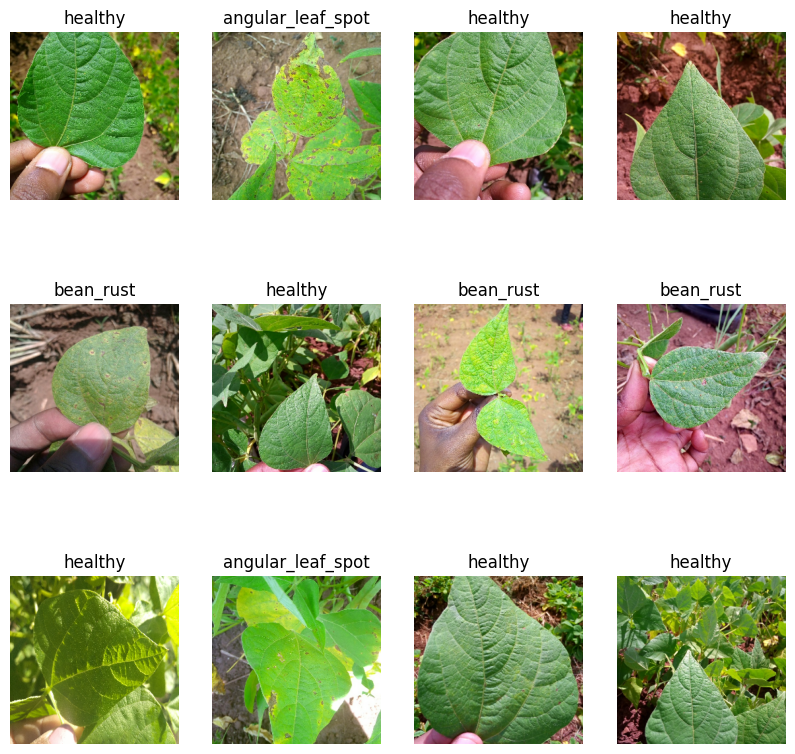

In [13]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
# Creating a Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [18]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
# Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
# Load the VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [21]:
# Freeze the base model's layers to prevent them from being trained
base_model.trainable = False

In [22]:
# Create a new model on top of the pre-trained base model
n_classes = 10
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

In [23]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [24]:
# Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/30
38/38 [==============================] - 979s 25s/step - loss: 23.9174 - accuracy: 0.6075 - val_loss: 7.2814 - val_accuracy: 0.7589
Epoch 2/30
38/38 [==============================] - 685s 18s/step - loss: 2.4140 - accuracy: 0.6833 - val_loss: 0.9719 - val_accuracy: 0.7411
Epoch 3/30
38/38 [==============================] - 655s 17s/step - loss: 0.9549 - accuracy: 0.6433 - val_loss: 0.8229 - val_accuracy: 0.7679
Epoch 4/30
38/38 [==============================] - 667s 18s/step - loss: 0.8398 - accuracy: 0.6658 - val_loss: 0.7381 - val_accuracy: 0.8125
Epoch 5/30
38/38 [==============================] - 858s 23s/step - loss: 0.7438 - accuracy: 0.7175 - val_loss: 0.7086 - val_accuracy: 0.7946
Epoch 6/30
30/38 [======================>.......] - ETA: 3:13 - loss: 0.7394 - accuracy: 0.7013

In [ ]:
# Evaluate the model on the test dataset
scores = model.evaluate(test_ds)


In [ ]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()